In [1]:
%pylab inline
%matplotlib inline

import os
os.chdir("/Users/Bya/git/predictEPL/MyFunctions/")
from dataIO import GetFilenames, csv_dic_df
from converter import toSeconds

import time
import pandas as pd
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Populating the interactive namespace from numpy and matplotlib


### Preprocessing Function

In [2]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import replacers

def cleanHash(word):
    if word[0] == '#':
        return word[1::]
    elif word[0] == '@':
        return '@'
    elif word[0:4] == 'http':
        return 'http'
    else:
        return word

def preprocessing_tweet(tweet, debug = False):
    if debug:
        print("====================================")
        print("[Original Tweet]: \n\n %s \n\n" % tweet)


    # can't -> cannot, bya's -> bya is
    replacer = replacers.RegexpReplacer()
    tweet = replacer.replace(tweet)
    if debug:
        print("====================================")
        print("[Replaced Tweet]: \n\n %s \n\n" % tweet)


    # Tweet tokenizer and lower case
    words = TweetTokenizer().tokenize(tweet)
    words = [word.lower() for word in words]
    if debug:
        print("====================================")
        print("[Tokenized Tweet]: \n\n %s \n\n" % words)


    # defining stopwords
    english_stops = set(stopwords.words('english'))
    english_stops_added = english_stops | {'!', '.', ',', ':', ';', '#', '?', 'RT', '-', '@', 'rt'}
    words = [word for word in words if word not in english_stops_added]
    if debug:
        print("====================================")
        print("[Cleaned Stopwords Tweet]: \n\n %s \n\n" % words)



    # words = map(lambda word: cleanHash(word), words)
    words = [cleanHash(word) for word in words]
    if debug:
        print("====================================")
        print("[Clean hash Tweet]: \n\n %s \n\n" % words)



    # Stemmer
    stemmer = PorterStemmer()
    words_stemmed = list(map(lambda word: stemmer.stem(word), words))
    if debug:
        print("====================================")
        print("[Stemmed hash Tweet]: \n\n %s \n\n" % words_stemmed)



    # Cleaning not useful Tweets
    # ex: Watch Live Stream
    pattern1 = ["watch", "live", "stream"]
    good_tweet = True
    if pattern1[0] in words and pattern1[1] in words and pattern1[2] in words:
        good_tweet = False
        if debug:
            print("====================================")
            print("[Not good Tweet!]: \n\n detected: \n\n %s" % pattern1)
    
    return words, words_stemmed, good_tweet

### Read NRC Emotion-Lexicon and create dictionary

In [3]:
# read Emotion-Lexicon.txt
pathData = "/Users/Bya/Dropbox/Research/resources/NRC-Emotion-Lexicon-v0.92/"
os.chdir(pathData)
with open("Emotion-Lexicon.txt", 'r') as emoleRaw:
        emoleRaw = emoleRaw.readlines()


# create dic
dic_emolex = {}
dic_emolex_stemmed = {}

for line in emoleRaw:
    word, category, flag = line.split()
    flag = int(flag)
    
    if word not in dic_emolex:
        dic_emolex[word] = {}
        dic_emolex_stemmed[PorterStemmer().stem(word)] = {}
    
    dic_emolex[word][category] = flag
    dic_emolex_stemmed[PorterStemmer().stem(word)][category] = flag
    dic_emolex_stemmed[PorterStemmer().stem(word)]["_original_word"] = word

print("All Words: %s" % len(dic_emolex.keys()))

All Words: 14182


### Tweet's Emotion-Lexicon count

In [4]:
# sum of all words emotion-lexicon

def tweet_emolex(words, words_stemmed, good_tweet, debug = False):
    
    dic_tweet_emolex = {
        'anger': 0,
        'fear': 0,
        'disgust': 0,
        'sadness': 0,
        'surprise': 0,
        'trust': 0,
        'joy': 0,
        'anticipation': 0,
        'positive': 0,
        'negative': 0,
    }
    
    if not good_tweet:
        return dic_tweet_emolex


    for i in range(len(words)):
        # search word on non-stemmed dictionary
        if words[i] in dic_emolex:
            if debug:
                print("w->d")
                print(words[i])
                print(dic_emolex[words[i]])

            for key in dic_tweet_emolex.keys():
                dic_tweet_emolex[key] += dic_emolex[words[i]][key]
        
        # search stemmed word on non-stemmed dictionary
        elif words_stemmed[i] in dic_emolex:
            if debug:
                print("sw->d")
                print(words[i])
                print(words_stemmed[i])
                print(dic_emolex[words_stemmed[i]])

            for key in dic_tweet_emolex.keys():
                dic_tweet_emolex[key] += dic_emolex[words_stemmed[i]][key]

        # search stemmed word on stemmed dictionary
        elif words_stemmed[i] in dic_emolex_stemmed:
            if debug:
                print("sw->sd")
                print(words[i])
                print(words_stemmed[i])
                print(dic_emolex_stemmed[words_stemmed[i]])

            for key in dic_tweet_emolex.keys():
                dic_tweet_emolex[key] += dic_emolex_stemmed[words_stemmed[i]][key]

    return dic_tweet_emolex

### Plot Emotion-Lexion

In [5]:
def create_minute_dics_emolex(df, side, category, cumulative = False):
    minutes = range(120) 
    dic_minutes = {}

    for minute in minutes:    
        try:
            if cumulative:
                dic_minutes[minute] = sum(df[(df['side'] == side) & \
                                                    (df['ith_minute'] < minute + 1)][category])
            else:
                dic_minutes[minute] = sum(df[(df['side'] == side) & \
                                                    (df['ith_minute'] > minute) & \
                                                    (df['ith_minute'] < minute + 1)][category])
        except:
            dic_minutes[minute] = 0
        
    return (dic_minutes)


def plot_emolex(home_team, list_dic_minutes, colors, categorys, i_plot,limit=True):

    ax = plt.subplot(3,2,i_plot)
    if limit:
        ax.set_xlim([0, 60])
    else:
        ax.set_xlim([0, 120])

    for i in range(len(list_dic_minutes)):
        tweets = tuple(list(list_dic_minutes[i].values()))
        plot1 = plt.plot(tweets, label=categorys[i], alpha=0.5, color=colors[i])

    
    plt.xlabel('Minutes')
    plt.ylabel('Emotion Signals')
    plt.title('Emotion-Lexicon  (Home Team: %s)'  % home_team)
    plt.legend()
    plt.tight_layout()


def plot_three(df, home_team, away_team):
    side = ['home', 'away', 'both']
    categorys_neg = ['anger', 'fear', 'disgust', 'sadness', 'surprise']
    colors_neg = ['red', 'darkorange', 'darksalmon', 'palegreen', 'darkgreen']
    categorys_pos = ['trust', 'joy', 'anticipation']
    colors_pos = ['skyblue', 'purple', 'blue']
    list_dic_minutes = []
    categorys_sent = ['positive', 'negative']
    colors_sent = ['green', 'red']

    plt.figure(figsize=(15, 20))

    list_dic_minutes = []
    for category in categorys_neg:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[0], category))
    plot_emolex(home_team, list_dic_minutes, colors_neg, categorys_neg, 1, True)

    list_dic_minutes = []
    for category in categorys_pos:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[0], category))
    plot_emolex(home_team, list_dic_minutes, colors_pos, categorys_pos, 3, True)


    list_dic_minutes = []
    for category in categorys_sent:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[0], category))
    plot_emolex(home_team, list_dic_minutes, colors_sent, categorys_sent, 5, True)

    
    list_dic_minutes = []
    for category in categorys_neg:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[1], category))
    plot_emolex(away_team, list_dic_minutes, colors_neg, categorys_neg, 2, True)

    list_dic_minutes = []
    for category in categorys_pos:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[1], category))
    plot_emolex(away_team, list_dic_minutes, colors_pos, categorys_pos, 4, True)


    list_dic_minutes = []
    for category in categorys_sent:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[1], category))
    plot_emolex(away_team, list_dic_minutes, colors_sent, categorys_sent, 6, True)


    plt.show()

In [6]:
dic_results_5 = {
3:"""
1-0	(17)NAISMITH STEVEN
2-0	(22)NAISMITH STEVEN
2-1	MATIC NEMANJA(36)
3-1	(82)NAISMITH STEVEN
""",
    
1:"""
1-0	(31)WALCOTT THEO
2-0	(85)GIROUD OLIVIER
""",

2:"""
0-0	No Scores
0-1	IHEANACHO KELECHI(90)
""",

5:"""
1-0	(35)JEROME CAMERON
2-0	(52)HOOLAHAN WES
3-0	(67)JARVIS MATTHEW
3-1	COOK STEVE(81)
""",
    
8:"""
0-0	No Scores
1-0	(59)IGHALO ODION
""",
9: """
0-0
0-0
""",
    
7:"""
0-0	No Scores
1-0	(49)BLIND DALEY
2-0	(Pen70)HERRERA ANDER
2-1	BENTEKE CHRISTIAN(84)
3-1	(86)MARTIAL ANTHONY
""",

6:"""
0-0	No Scores
0-1	MASON RYAN(82)
""",
    
4:"""
0-1	GREALISH JACK(39)
0-2	GIL CARLES(63)
1-2	(72)DE LAET RITCHIE
2-2	(82)VARDY JAMIE
3-2	(89)DYER NATHAN
""",
    
10 :
"""
1-0	(9)PAYET DIMITRI
2-0	(48)PAYET DIMITRI
"""
    }

### Reading Soccer Match datas and Create Emotion-Lexicon Dataframe

In [7]:
# read csv data as dataframe
def create_emolex_df(filePath):
    home_team = filePath.split("_")[0][5::]
    away_team = filePath.split("_")[2][0:-4]

    df = csv_dic_df(filePath)

    # adding minute column
    df['ith_minute'] = [float(ith_minute) for ith_minute in df['ith_minute']]

    # adding Emotion-Lexicon columns
    df['anger'] = 0
    df['fear'] = 0
    df['disgust'] = 0
    df['sadness'] = 0
    df['surprise'] = 0
    df['trust'] = 0
    df['joy'] = 0
    df['anticipation'] = 0
    df['positive'] = 0
    df['negative'] = 0


    # adding emotion-lexicon values to dataframe
    for i in range(len(df)):
        tweet = df.loc[i]['text']

        words, words_stemmed, good_tweet = preprocessing_tweet(tweet)
        dic_counted = tweet_emolex(words, words_stemmed, good_tweet)

        df.loc[i, 'anger'] = dic_counted['anger']
        df.loc[i, 'anticipation'] = dic_counted['anticipation']
        df.loc[i, 'disgust'] = dic_counted['disgust']
        df.loc[i, 'fear'] = dic_counted['fear']
        df.loc[i, 'joy'] = dic_counted['joy']
        df.loc[i, 'negative'] = dic_counted['negative']
        df.loc[i, 'positive'] = dic_counted['positive']
        df.loc[i, 'sadness'] = dic_counted['sadness']
        df.loc[i, 'surprise'] = dic_counted['surprise']
        df.loc[i, 'trust'] = dic_counted['trust']
    
    return df

### Counting Emotion and Sentiment

In [8]:
def calculate_df_emolex(df, side):
    dic = {
        'anger': [sum(df[df['side'] == side]['anger'])],
        'fear': [sum(df[df['side'] == side]['fear'])],
        'disgust': [sum(df[df['side'] == side]['disgust'])],
        'sadness': [sum(df[df['side'] == side]['sadness'])],
        'surprise': [sum(df[df['side'] == side]['surprise'])],
        'trust': [sum(df[df['side'] == side]['trust'])],
        'joy': [sum(df[df['side'] == side]['joy'])],
        'anticipation': [sum(df[df['side'] == side]['anticipation'])]
    }
    
    
    dic_sent = {
        'positive': [sum(df[df['side'] == side]['positive'])],
        'negative': [sum(df[df['side'] == side]['negative'])]
    }
    
    
    emolex_sum = float(sum(list(dic.values())))
    emolex_sum_sent = float(sum(list(dic_sent.values())))

    for key in dic.keys():
        dic[key].append(dic[key][0] / emolex_sum)
    
    for key in dic_sent.keys():
        dic_sent[key].append(dic_sent[key][0] / emolex_sum_sent)
    
    return dic, dic_sent

### Ploting and Calculating GW10

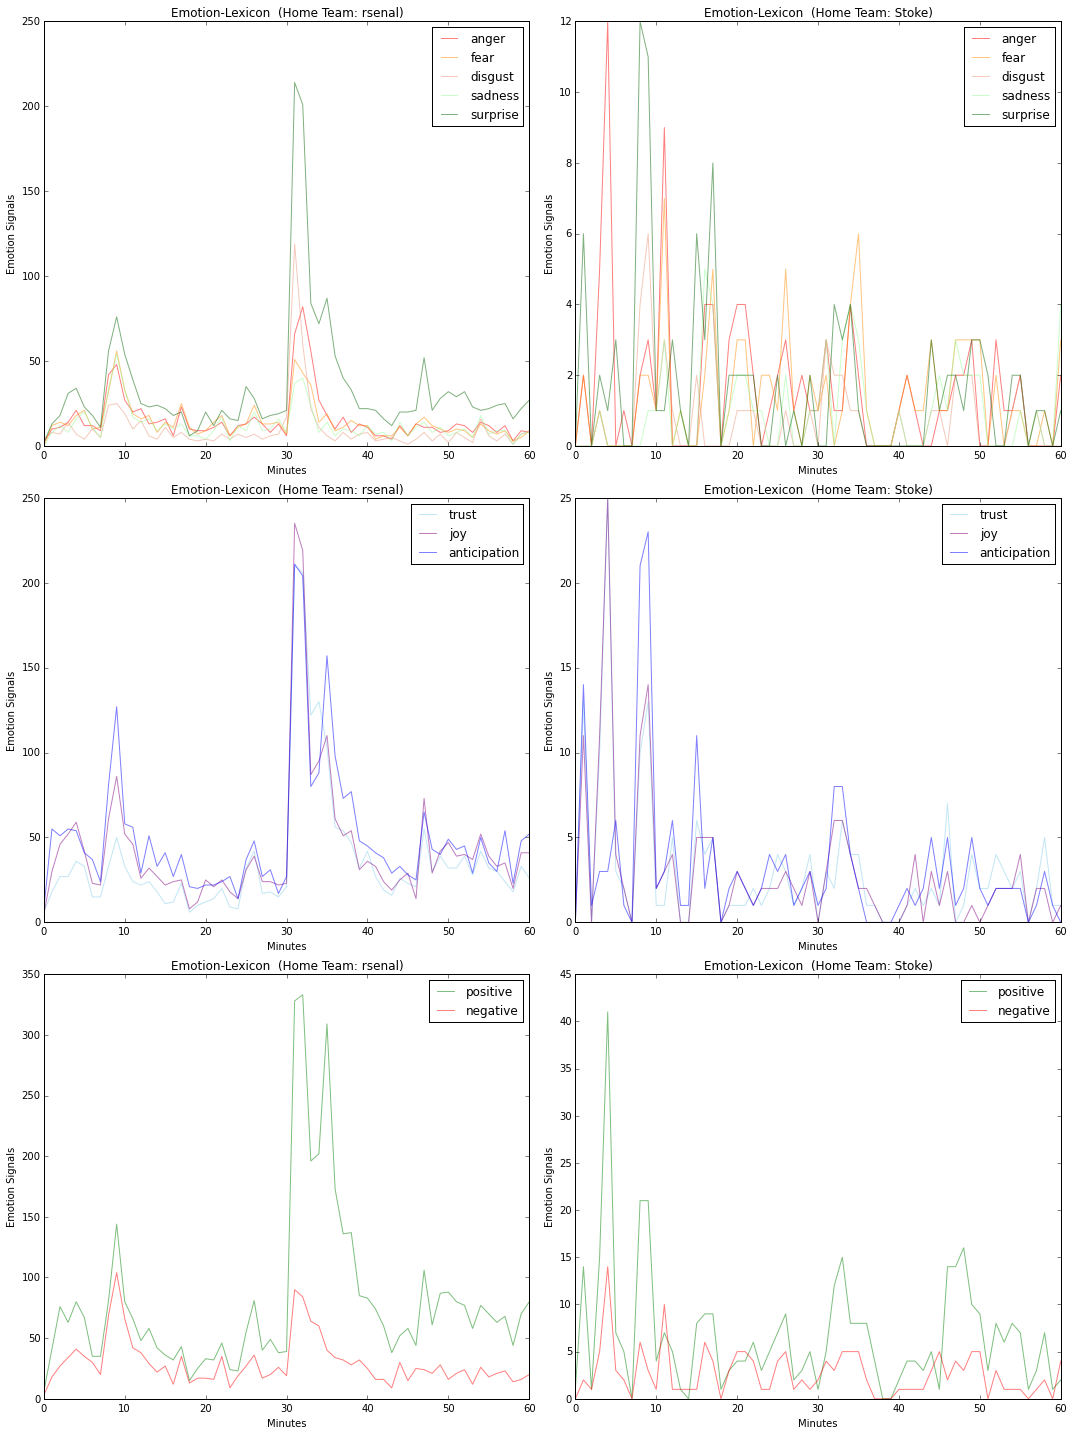


[Time]: 64.65482497215271

[Game]: rsenal vs Stoke

1-0	(31)WALCOTT THEO
2-0	(85)GIROUD OLIVIER




******[Emotions]******

In [ ]:
# choosing data
os.chdir('/Users/Bya/Dropbox/Research/datas/Results/NB_Short_Long/')
filenames = GetFilenames('GW' + str(5))

game_key = 1
for filename in filenames:
#     filename = filenames[2]
    home_team = filename.split("_")[0][5::]
    away_team = filename.split("_")[2][0:-4]
    
    start = time.time()

    # create df
    df = create_emolex_df(filename)

    # plots
    plot_three(df, home_team, away_team)

    # time
    print("\n[Time]: %s" % (time.time() - start))

    # games
    print("================================")
    print("\n[Game]: %s vs %s" % (home_team, away_team))

    # goals and minutes
    print(dic_results_5[game_key])
    game_key += 1

    # calculated dics
    dic_home, dic_sent_home = calculate_df_emolex(df, 'home')
    dic_away, dic_sent_away = calculate_df_emolex(df, 'away')

    print("\n\n\n******[Emotions]******")
    print("---------------------------------------------------")
    print("    CATEGORY \t\t HOME TEAM \t AWAY TEAM")
    for key in dic_home.keys():
        print("---------------------------------------------------")
        print("%12s \t\t %.0f (%.2f) \t %.0f (%.2f)" % (key, dic_home[key][0], dic_home[key][1], 
                                     dic_away[key][0], dic_away[key][1]))

    print("\n\n\n******[Sentiment]******")
    print("---------------------------------------------------")
    print("    CATEGORY \t\t HOME TEAM \t AWAY TEAM")
    for key in dic_sent_home.keys():
        print("---------------------------------------------------")
        print("%12s \t\t %.0f (%.2f) \t %.0f (%.2f)" % (key, dic_sent_home[key][0], dic_sent_home[key][1], 
                                     dic_sent_away[key][0], dic_sent_away[key][1]))